In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from annoy import AnnoyIndex
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from pathlib import Path
from transformers import pipeline
from tqdm import tqdm
import time
import multiprocessing

In [84]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [74]:
def jsonl_list_to_dataframe(file_list, columns=['language', 'docstring', 'code']):
    """Load a list of jsonl.gz files into a pandas DataFrame."""
    return pd.concat([pd.read_json(f,
                                   orient='records', 
                                   compression='gzip',
                                   lines=True)[columns] 
                      for f in file_list], sort=False)

In [75]:
def get_dfs(path, splits = ["train", "valid", "test"]):
    """Grabs the different data splits and converts them into dataframes"""
    dfs = []
    for split in splits:
        files = sorted((path/split).glob("**/*.gz"))
        df = jsonl_list_to_dataframe(files)
        dfs.append(df)
        
    return dfs

In [76]:
path = Path('/mnt/sdc/zheng/sde/data_bert')
java_df = get_dfs(path/"java/final/jsonl", ["train"])[0]
java_df.head()

,language,docstring,code
0,java,Bind indexed elements to the supplied collecti...,protected final void bindIndexed(Configuration...
1,java,Set {@link ServletRegistrationBean}s that the ...,public void setServletRegistrationBeans(\n\t\t...
2,java,Add {@link ServletRegistrationBean}s for the f...,public void addServletRegistrationBeans(\n\t\t...
3,java,Set servlet names that the filter will be regi...,public void setServletNames(Collection<String>...
4,java,Add servlet names for the filter.\n@param serv...,public void addServletNames(String... servletN...


In [145]:
java_df['code'].iloc[3]

'public BufferedReader openBufferedStream() throws IOException {\n    Reader reader = openStream();\n    return (reader instanceof BufferedReader)\n        ? (BufferedReader) reader\n        : new BufferedReader(reader);\n  }'

In [77]:
# tokenizer
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

size= 10000
tokenizer = ByteLevelBPETokenizer(
    '/home/zheng/sde_course/hugg/'+str(size)+'/esperberto_'+str(size)+'size-vocab.json',
    '/home/zheng/sde_course/hugg/'+str(size)+'/esperberto_'+str(size)+'size-merges.txt',
)
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)

print(
    tokenizer.encode("Mi estas Julien.")
)
# Encoding(num_tokens=7, ...)
# tokens: ['<s>', 'Mi', 'Ġestas', 'ĠJuli', 'en', '.', '</s>']

Encoding(num_tokens=11, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [78]:
java_df['code'] = java_df['code'].astype('str')

In [79]:
code_list = java_df['code'].values

In [103]:
t = time.time()
token_list = [tokenizer.encode(code_list[i]).tokens for i in range(len(code_list))]
#token_list = [tokenizer.encode(code_list[i]).tokens for i in range(5000)]
print('Time to tokenization: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to tokenization: 9.78 mins


#word2vec

In [104]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

path = get_tmpfile("word2vec.model")

model = Word2Vec(min_count=2, size=768, window=5, workers=cores)
model.save("word2vec.model")

In [105]:
t = time.time()

model.build_vocab(token_list, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to build vocab: 0.39 mins


In [106]:
t = time.time()

model.train(token_list, total_examples=model.corpus_count, epochs=10, report_delay=1)

model.save("word2vec_java.model")
print('Time to training: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to training: 10.69 mins


In [109]:
model.init_sims(replace=True)

In [189]:
model.wv.most_similar(positive=["return"])

[('break', 0.5569101572036743),
 ('//', 0.5389456748962402),
 ('continue', 0.5326634049415588),
 ('if', 0.516125500202179),
 ('throw', 0.4965173602104187),
 ('while', 0.46331149339675903),
 ('try', 0.46232736110687256),
 ('Ġ=', 0.44039225578308105),
 ('}', 0.417204350233078),
 ('boolean', 0.411263644695282)]

# evaluate word2vec embedding

In [151]:
path = Path('/mnt/sdc/zheng/sde/data_bert')
java_df = get_dfs(path/"java/final/jsonl", ["test"])[0]
python_df = get_dfs(path/"python/final/jsonl", ["test"])[0]
python_df.head()

,language,docstring,code
0,python,Extracts video ID from URL.,"def get_vid_from_url(url):\n """"""Extract..."
1,python,str->list\n Convert XML to URL List.\n F...,"def sina_xml_to_url_list(xml_data):\n """"""st..."
2,python,From http://cdn37.atwikiimg.com/sitescript/pub...,"def makeMimi(upid):\n """"""From http://cdn37...."
3,python,wrapper,"def fc2video_download(url, output_dir = '.', m..."
4,python,Downloads Dailymotion videos by URL.,"def dailymotion_download(url, output_dir='.', ..."


In [152]:
python_df.shape

(22176, 3)

In [153]:
23107+22176

45283

In [118]:
langs_df = pd.concat([java_df, python_df]).sample(frac = 0.01)

In [119]:
langs_df.shape

(384, 3)

In [127]:
langs_df['code'] = langs_df['code'].astype('str')
test_list = langs_df['code'].values

In [128]:
t = time.time()
test_token_list = [tokenizer.encode(test_list[i]).tokens for i in range(len(test_list))]
print('Time to tokenization: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to tokenization: 0.02 mins


In [134]:
def get_features(methods, extractor):
    method_features = []
    for method in tqdm(methods):
        features = np.zeros(512)
        for word in method:
            try:
                features += extractor[word]
            except:
                pass
        features /= len(method)
        method_features.append(features)
    
    return method_features

In [135]:
X_O = get_features(langs_df.code.values, model.wv)
y = langs_df.language.values

100%|██████████| 384/384 [00:01<00:00, 199.73it/s]


In [136]:
for i, lang in enumerate(y):
    if lang == 'java':
        y[i] = 0
    elif lang == 'python':
        y[i] = 1
y = y.astype(np.int32)

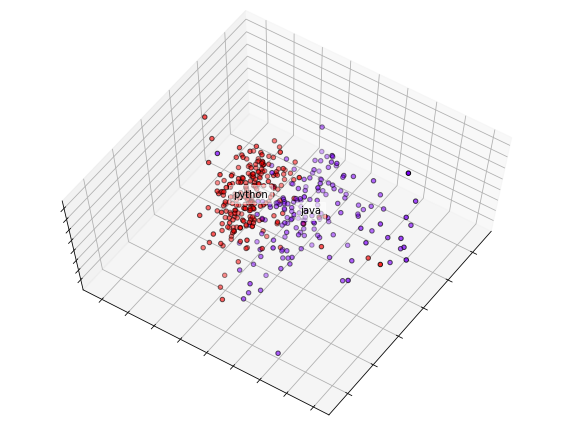

In [155]:
import copy
X = copy.deepcopy(X_O)
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, .5, .95, 1], elev=68, azim=34)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label in [('java', 0), ('python', 1)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean(),
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
# y = np.choose(y, [0, 1]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.rainbow,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

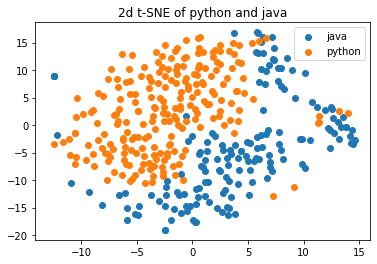

In [140]:
import pylab as pl
from sklearn.manifold import TSNE

X = copy.deepcopy(X_O)
X = TSNE(n_components=2, random_state=None,).fit_transform(X)

# Reorder the labels to have colors matching the cluster results
# y = np.choose(y, [0, 1]).astype(np.float)
pl.figure()
for name, label in [('java', 0), ('python', 1)]:
    pl.scatter(X[y==label,0], X[y==label,1], label=name)
pl.legend(['java','python'])
pl.title('2d t-SNE of python and java')

pl.show()

In [163]:
# load reddit dataset
df_reddit = pd.DataFrame(columns=['language','docstring','code'])
i = 0
with open('/mnt/sdc/zheng/sde/data/RC_2009-01','r') as json_file:
    for line in json_file:
        if i > 500:
            break
        parse_json = json.loads(line)
        df_reddit.loc[i] = ['reddit',parse_json['id'],parse_json['body']]
        i+=1

In [164]:
langs_df_with_reddit = pd.concat([langs_df, df_reddit])

In [165]:
X_O = get_features(langs_df_with_reddit.code.values, model.wv)
y = langs_df_with_reddit.language.values

100%|██████████| 885/885 [00:02<00:00, 394.64it/s]


In [166]:
for i, lang in enumerate(y):
    if lang == 'java':
        y[i] = 0
    elif lang == 'python':
        y[i] = 1
    elif lang == 'reddit':
        y[i] = 2
y = y.astype(np.int32)

/mnt/sdc/zheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support trans

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

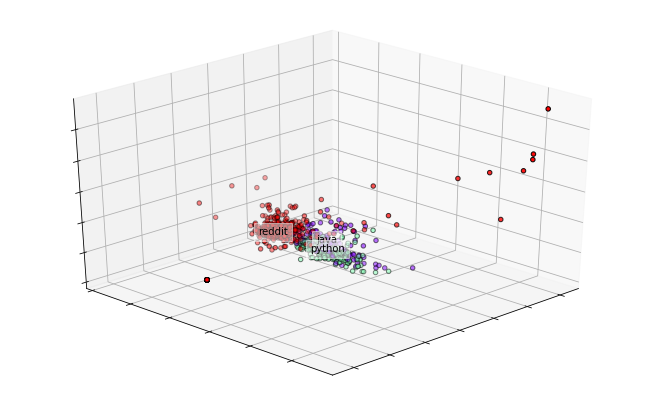

In [186]:
X = copy.deepcopy(X_O)
fig = plt.figure(1, figsize=(16, 9))
plt.clf()
ax = Axes3D(fig, rect=[0, .3, .55, .6], elev=30, azim=45)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label in [('java', 0), ('python', 1), ('reddit', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean(),
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
# y = np.choose(y, [0, 1]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.rainbow,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
fig.tight_layout()
fig.savefig('./picture/word2vec_3compare_3dpca.eps', format='eps', ppi=800)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

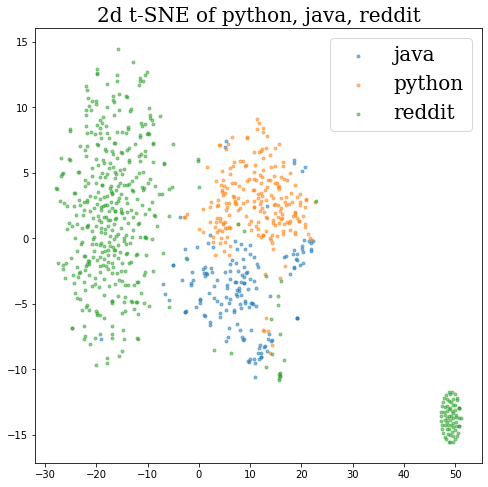

In [173]:
import pylab as pl
from sklearn.manifold import TSNE
f, ax = plt.subplots(1,1, figsize=(8,8))
font1 = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 20,
            }
X = copy.deepcopy(X_O)
X = TSNE(n_components=2, random_state=None,).fit_transform(X)

# Reorder the labels to have colors matching the cluster results
# y = np.choose(y, [0, 1]).astype(np.float)
for name, label in [('java', 0), ('python', 1), ('reddit', 2)]:
    ax.scatter(X[y==label,0], X[y==label,1], label=name, marker='.',alpha=0.5)
ax.legend(['java','python','reddit'],prop={'family' : 'serif', 'size': 20})
ax.set_title('2d t-SNE of python, java, reddit',font1)
f.savefig('./picture/word2vec_3compare_tsne.eps', format='eps', ppi=800)
plt.show()